# 0. IMPORTS

In [1]:
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas_profiling import ProfileReport


from sklearn.ensemble import RandomForestRegressor as RF
from umap import UMAP
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE


from kaggle.api.kaggle_api_extended import KaggleApi
from IPython.display import display, HTML
import warnings
from os import remove
from zipfile import ZipFile
import pickle

C:\Users\Noudy\envs\customer-segmentation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Noudy\envs\customer-segmentation\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Noudy\envs\customer-segmentation\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.i

## 0.1. Helper Functions

In [2]:
def silhouette_print(X, m, n_clusters,):

    model = m(n_clusters = n_clusters)
    y = model.fit_predict(X)
    
    # Calculando as silhuetas de cada amostra
    silhouette_vals = silhouette_samples(X, y)

    # Calculando a pontuação média de silhueta do conjunto de dados
    silhouette_avg = silhouette_score(X, y)

    # Plotando as silhuetas de cada amostra e seus clusters correspondentes
    fig, ax = plt.subplots()
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(y)):
        cluster_silhouette_vals = silhouette_vals[y == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)
        y_ticks.append((y_lower + y_upper) / 2)
    
    plt.title("K = {}".format(n_clusters))
    
    # Plotando a linha de silhueta média
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(np.unique(y))
    ax.set_ylabel("Cluster")
    ax.set_xlim([-0.2, 1])
    ax.set_xlabel("Silhouette coefficient")
    plt.show()

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
seed = 0

## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.dataset_download_file('carrie1/ecommerce-data', 'data.csv');

with ZipFile('data.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df_raw = pd.read_csv('data.csv', encoding = 'unicode_escape')

remove('data.csv')
remove('data.csv.zip')

# 1. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

## 1.2. Data Dimensions

In [6]:
print('Number of Columns: {}'.format(df1.shape[1]))
print('Number of Rows: {}'.format(df1.shape[0]))

Number of Columns: 8
Number of Rows: 541909


## 1.3. Data Types

In [7]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.5. Fillout NA

In [9]:
df1[df1["Description"].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [10]:
df1 = df1.dropna()

## 1.6. Changing Data Types

In [11]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

## 1.7. Descriptive Statistics

In [12]:
num_attr = df1[["Quantity", "UnitPrice"]]
cat_attr = df1[["InvoiceNo", "StockCode", "Country"]]

### 1.7.1. Numerical Attributes

In [13]:
minimum = pd.DataFrame(num_attr.min())
maximum = pd.DataFrame(num_attr.max())
range_ = maximum - minimum
mean = pd.DataFrame(num_attr.mean())
median = pd.DataFrame(num_attr.median())
std = pd.DataFrame(num_attr.std())
skew = pd.DataFrame(num_attr.skew())
kurtosis = pd.DataFrame(num_attr.kurtosis())

description = pd.concat([minimum, maximum, range_, mean, median, std, skew, kurtosis], axis = 1)
description.columns = ['Min', 'Max', 'Range', 'Mean', "Median", 'StD', 'Skew', 'Kurtosis']
description

,Min,Max,Range,Mean,Median,StD,Skew,Kurtosis
Quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,0.182663,94317.563673
UnitPrice,0.0,38970.0,38970.0,3.460471,1.95,69.315162,452.219019,246924.542988


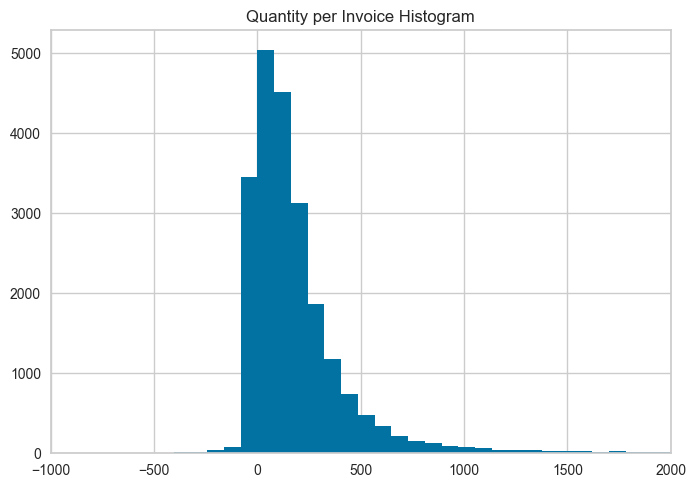

In [14]:
df1[['InvoiceNo', "Quantity"]].groupby("InvoiceNo").sum().hist(bins = 2000)
plt.title("Quantity per Invoice Histogram")
plt.xlim([-1000, 2000]);

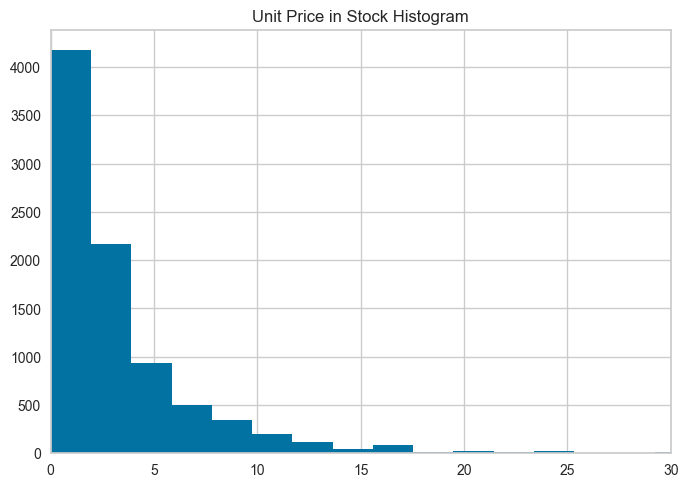

In [15]:
aux = df1[["StockCode", "UnitPrice"]].drop_duplicates()
aux.hist(bins = 20000)
plt.title("Unit Price in Stock Histogram")
plt.xlim([0, 30]);

### 1.7.2. Categorical Attributes

In [16]:
cat_attr.describe().T

,count,unique,top,freq
InvoiceNo,406829,22190,576339,542
StockCode,406829,3684,85123A,2077
Country,406829,37,United Kingdom,361878


# 2. VARIABLE FILTERING

In [17]:
df2 = df1.copy()

## 2.1. Row Filtering

In [18]:
df2 = df2[df2['StockCode'].str.match("[^A-Z]")]

## 2.2. Columns Filtering

# 3. FEATURE ENGINEERING

In [19]:
df3 = df2.copy()

## 3.1. Features Creation

### 3.1.1. Time Parameters

In [20]:
today = df3['InvoiceDate'].max()
time_min = today - datetime.timedelta(days = 90)
time_interval = (today - time_min).days

### 3.1.2. Source Data

In [21]:
df3['TotalPrice'] = df3.apply(lambda x: x['Quantity'] * x['UnitPrice'], axis = 1)

### 3.1.3. Features DataFrame

In [22]:
df_feat = df3[['CustomerID']].drop_duplicates().sort_values(by = 'CustomerID', ascending = True).reset_index(drop = True)

#### 3.1.3.1. Recency (Days)

In [23]:
recency = df3[df3['Quantity'] > 0].groupby('CustomerID').max()[['InvoiceDate']].reset_index().rename(columns = {'InvoiceDate' : "Recency"})
recency["Recency"] = recency['Recency'].apply(lambda x: (today - x).days)

df_feat = df_feat.merge(recency, on = "CustomerID", how = "left").fillna(0)

#### 3.1.3.2. Frequency (Purchases/Day over time)

In [24]:
frequency = df3[df3['Quantity'] > 0][df3['InvoiceDate'] > time_min][['CustomerID', "InvoiceNo"]].drop_duplicates().groupby(['CustomerID']).count().reset_index().rename(columns = {'InvoiceNo' : 'Frequency'})
frequency['Frequency'] = frequency["Frequency"]/time_interval

df_feat = df_feat.merge(frequency, on = "CustomerID", how = "left")

#### 3.1.3.3. Monetary

In [25]:
monetary = df3[['TotalPrice', 'CustomerID']].groupby('CustomerID').sum().reset_index().rename(columns = {"TotalPrice" : "Monetary"})

df_feat = df_feat.merge(monetary, on = 'CustomerID', how = 'left')

#### 3.1.3.4 Mean Basket Size

In [26]:
basket_size = df3[df3['Quantity'] > 0][['CustomerID', 'InvoiceNo', "Quantity"]].groupby(["CustomerID", "InvoiceNo"]).sum().reset_index()
basket_size = basket_size[["CustomerID", "Quantity"]].groupby('CustomerID').mean().reset_index().rename(columns = {"Quantity" : "MeanBasketSize"})

df_feat = df_feat.merge(basket_size, on = 'CustomerID', how = 'left')

#### 3.1.3.5. Average Ticket

In [27]:
mean_average_ticket = df3[["CustomerID", "InvoiceNo", "TotalPrice"]].groupby(['CustomerID', "InvoiceNo"]).sum().reset_index()
mean_average_ticket = mean_average_ticket[['CustomerID', "TotalPrice"]].groupby("CustomerID").mean().reset_index().rename(columns = {'TotalPrice' : "AverageTicket"})

df_feat = df_feat.merge(mean_average_ticket, on = "CustomerID", how = 'left')

#### 3.1.3.6. Total Quantity Purchased

In [28]:
total_quantity = df3[df3["Quantity"] > 0][['CustomerID', "Quantity"]].groupby("CustomerID").sum().reset_index().rename(columns = {"Quantity" : "TotalQuantity"})

df_feat = df_feat.merge(total_quantity, on = "CustomerID", how = 'left')

#### 3.1.3.7. Number of Returns

In [29]:
total_return = df3[df3["Quantity"] < 0][['CustomerID', "Quantity"]].groupby("CustomerID").sum().reset_index().rename(columns = {"Quantity" : "TotalReturn"})
total_return['TotalReturn'] = -total_return['TotalReturn']
df_feat = df_feat.merge(total_return, on = "CustomerID", how = 'left').fillna(0)

#### 3.1.3.8. Average Purchase Interval

In [30]:
aux = df3[df3['Quantity'] > 0][['CustomerID', "InvoiceDate"]].drop_duplicates().sort_values(by = ['CustomerID', "InvoiceDate"])
aux["NextCustomer"] = aux['CustomerID'].shift()
aux['NextInvoice'] = aux['InvoiceDate'].shift()
aux["AveragePurchaseInterval"] = aux.apply(lambda x: (x["InvoiceDate"] - x['NextInvoice']).days if x['CustomerID'] == x['NextCustomer'] else np.nan, axis = 1)
aux = aux.dropna()
aux2 = aux[["CustomerID", "AveragePurchaseInterval"]].groupby('CustomerID').mean().reset_index()

aux3 = df_feat.merge(aux2, on = "CustomerID", how = 'left')
aux4 = df3[['CustomerID', "InvoiceDate"]].groupby("CustomerID").max()
aux3 = aux3.merge(aux4, on = "CustomerID", how = 'left')
aux3 = aux3.apply(lambda x: x.fillna( (today - x['InvoiceDate']).days), axis = 1)
aux3.drop("InvoiceDate", inplace = True, axis = 1)

df_feat = aux3

# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [31]:
df4 = df_feat.copy()

## 4.1. Univariate Analysis

In [32]:
profile = ProfileReport(df4)
profile.to_file('univariate_analysis.html')

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.85it/s]


## 4.2. Bivariate Analysis

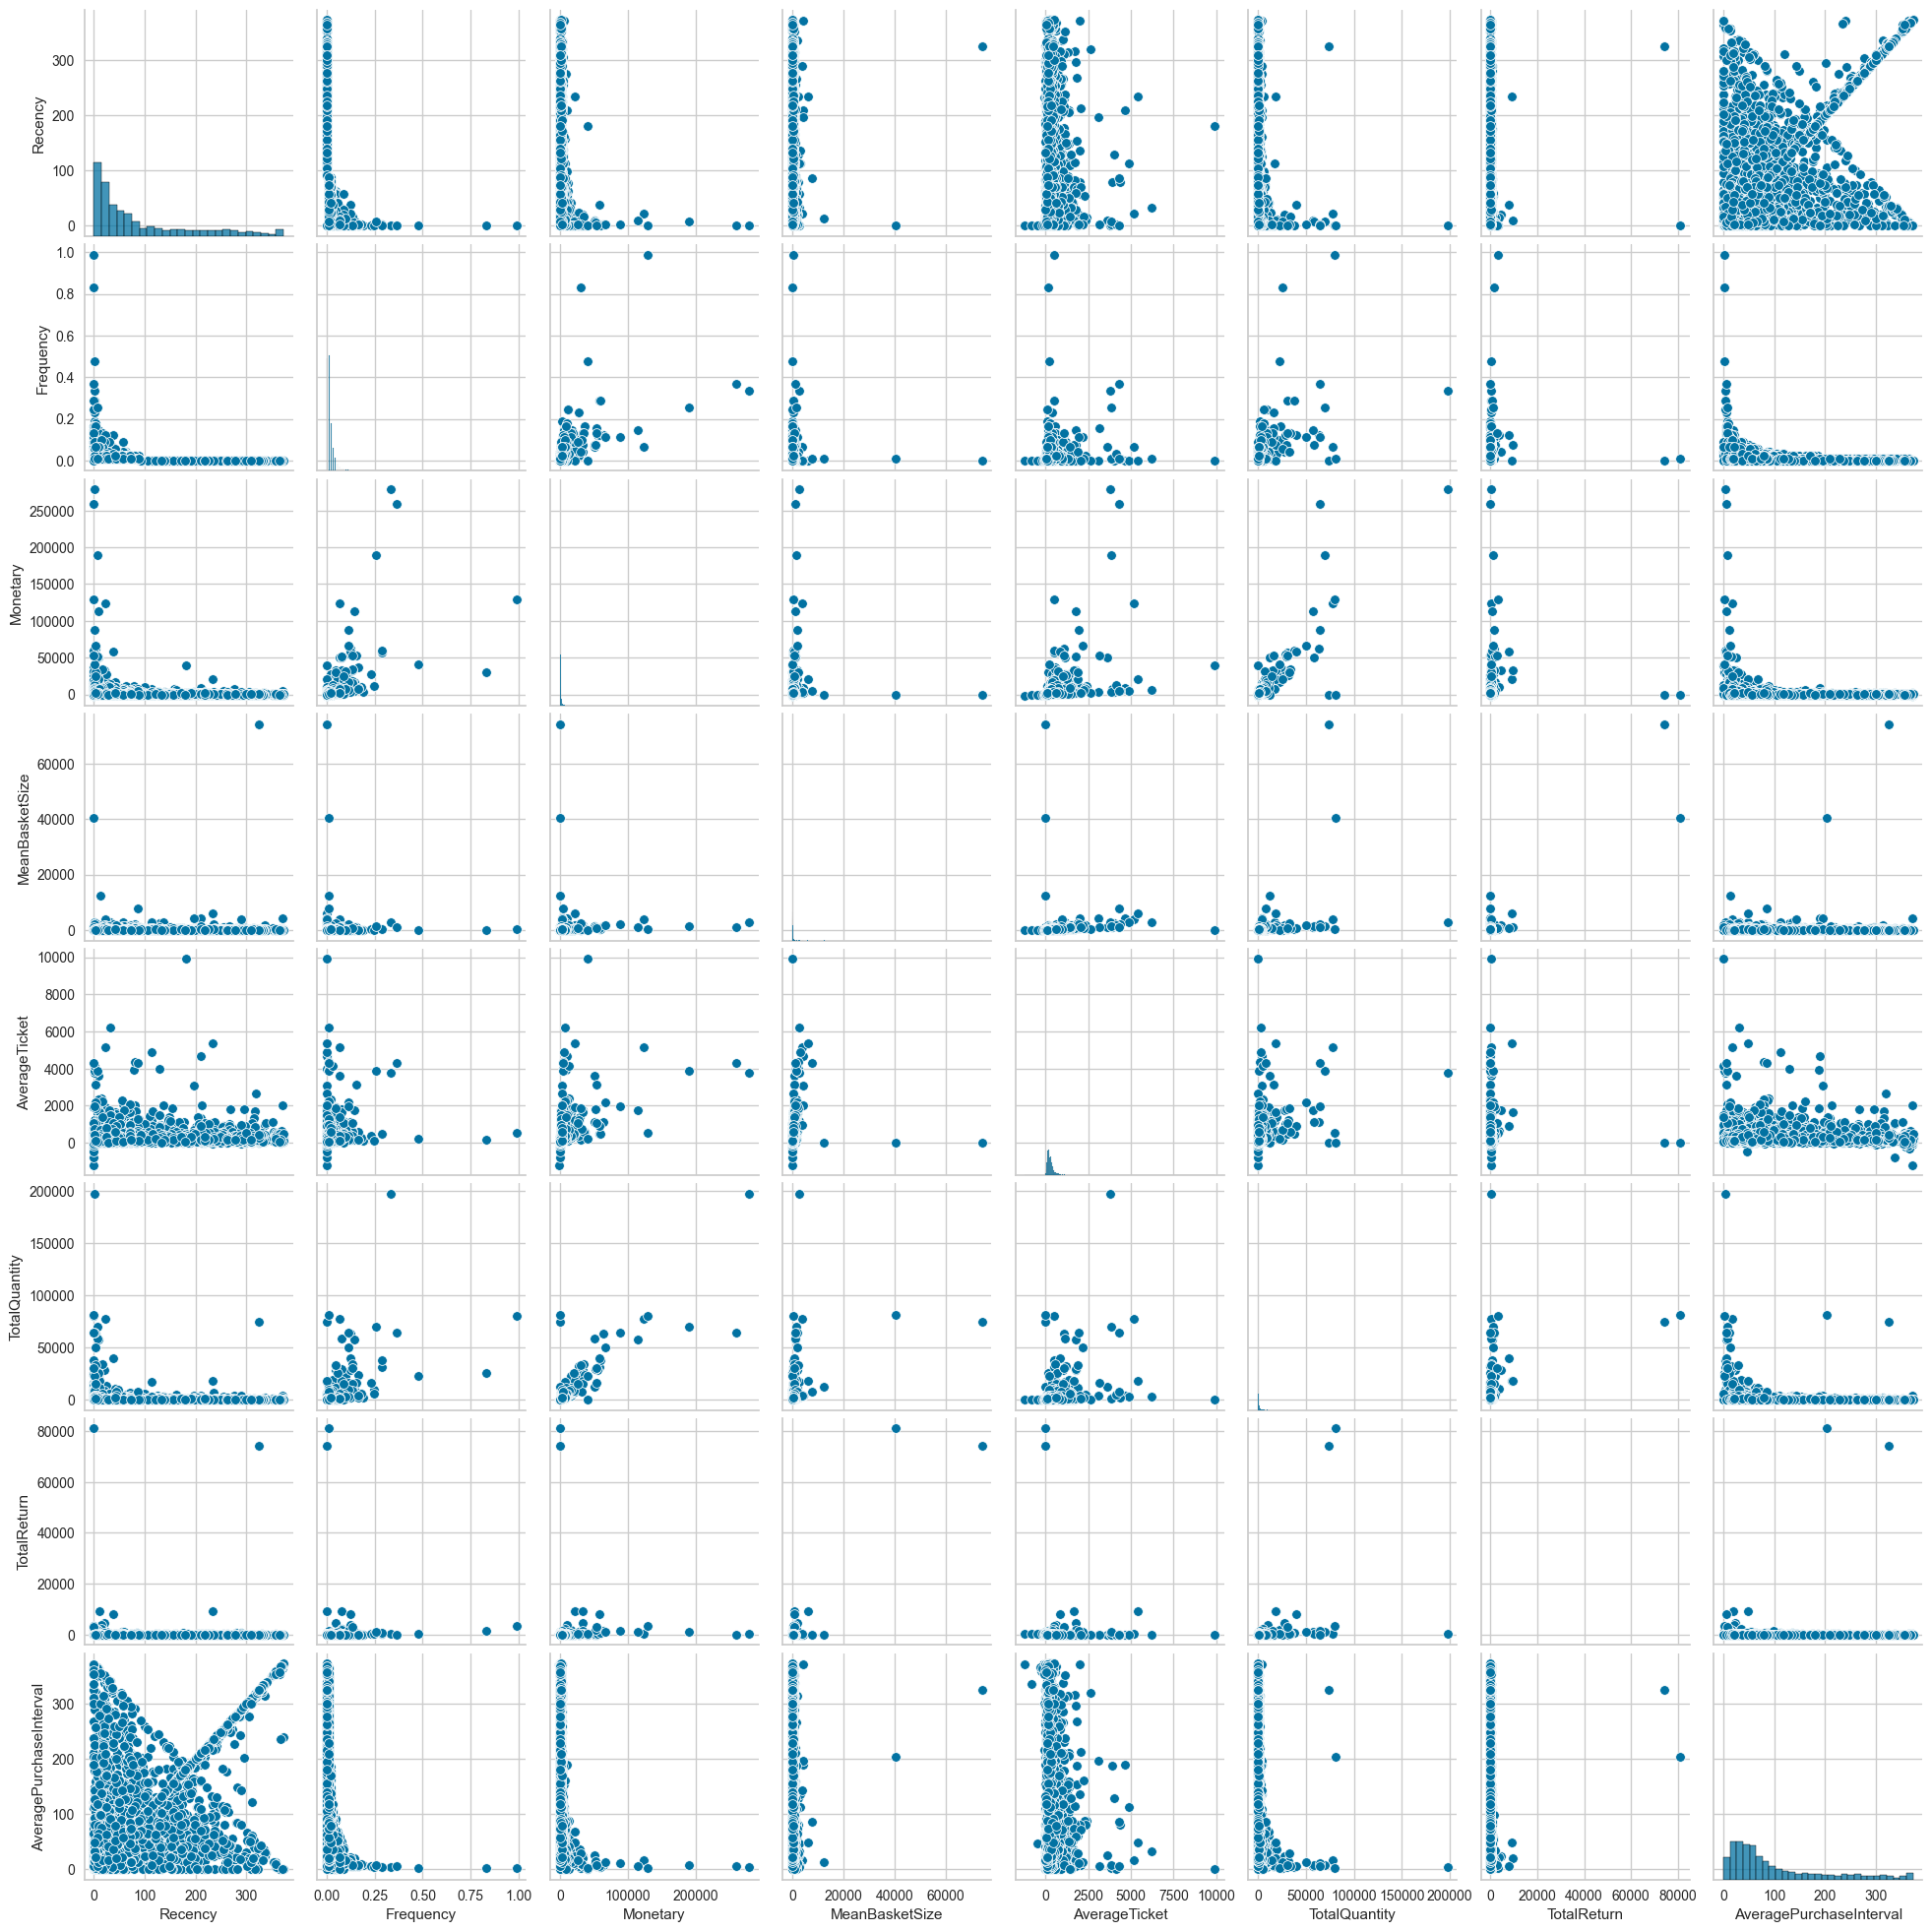

In [33]:
sns.pairplot(df4.drop('CustomerID', axis = 1));

## 4.3. Embedding Space

### 4.3.1. PCA

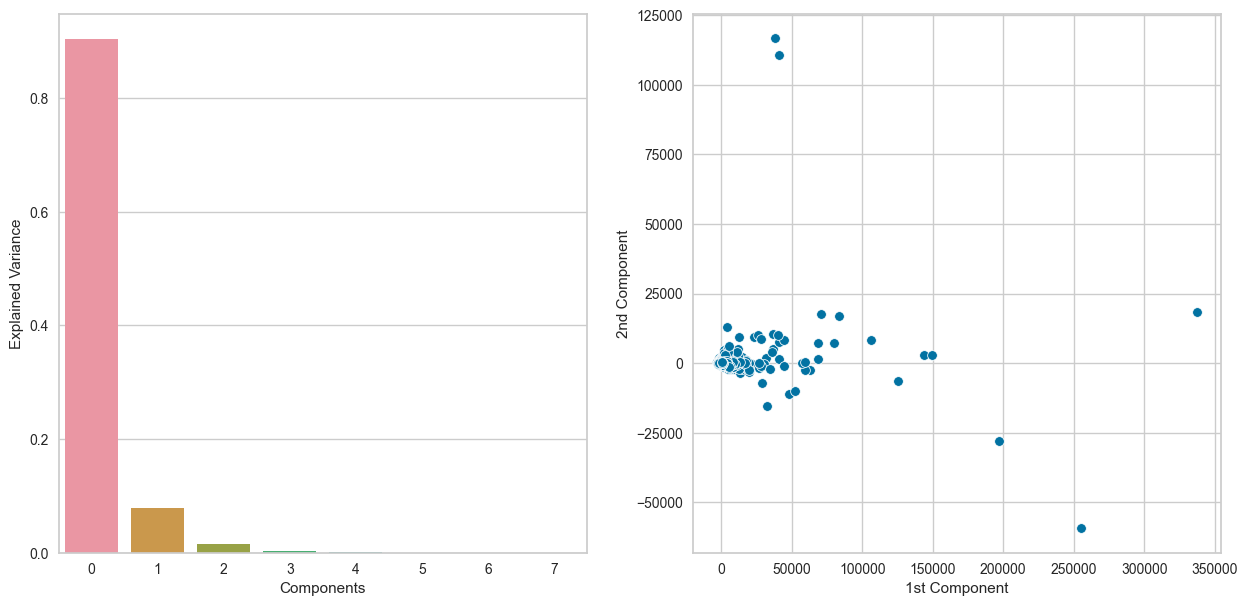

In [34]:
L = df_feat.drop(['CustomerID'], axis = 1).shape[1]
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(df_feat.drop(['CustomerID'], axis = 1)))

plt.figure(figsize = [15, 7])

plt.subplot(1, 2, 1)
sns.barplot(x = list(range(0, L)), y = pca.explained_variance_ratio_);
plt.xlabel("Components")
plt.ylabel("Explained Variance")

plt.subplot(1, 2, 2)
sns.scatterplot(x = 0, y = 1, data = pca_data);
plt.xlabel("1st Component")
plt.ylabel("2nd Component");

### 4.3.2. t-SNE

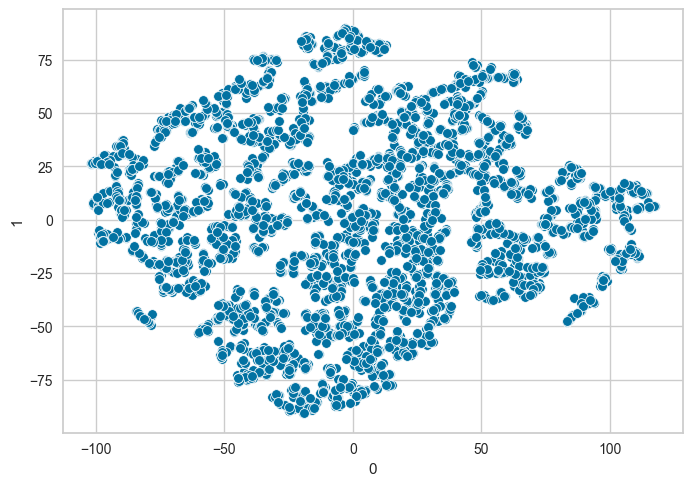

In [35]:
reducer = TSNE(n_components = 2, perplexity = 10, n_jobs = -1, random_state = seed)
tsne = pd.DataFrame(reducer.fit_transform(df_feat.drop('CustomerID', axis = 1)))

sns.scatterplot(x = 0, y = 1, data = tsne);

###  4.3.3. UMAP

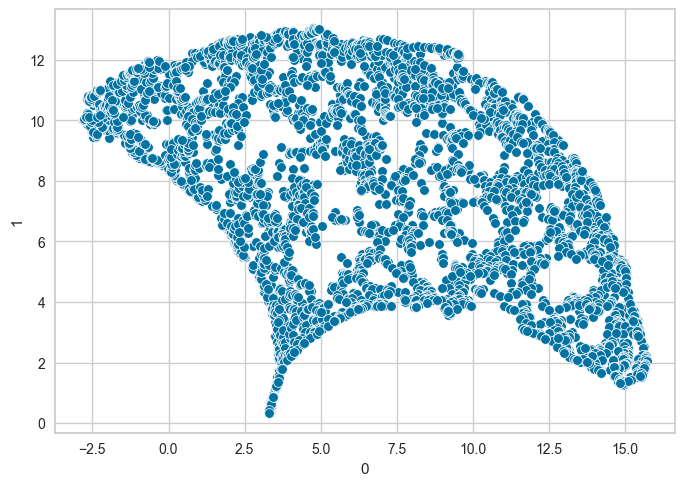

In [36]:
reducer = UMAP()
umap_emb = pd.DataFrame(reducer.fit_transform(df4))
sns.scatterplot(x = 0, y = 1, data = umap_emb);

### 4.3.4. Tree-based Embedding

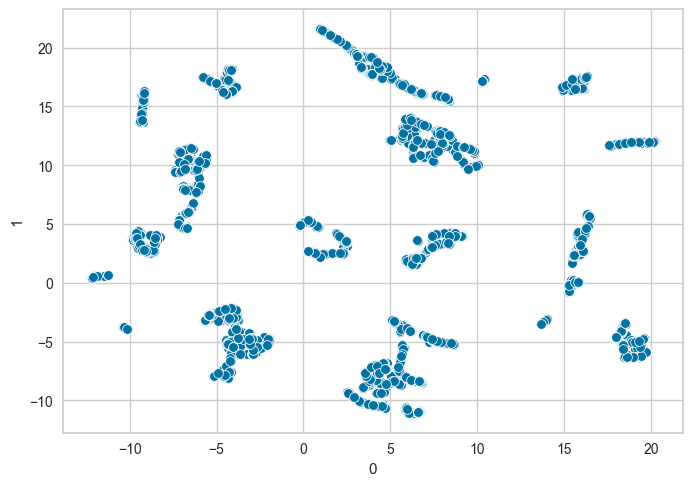

In [37]:
X = df4.drop('Monetary', axis = 1)
Y = df4['Monetary']

rf_emb = RF(random_state = seed)
rf_emb.fit(X, Y)
df_leaf = pd.DataFrame(rf_emb.apply(X))

reducer = UMAP(random_state = seed)
df_tree_emb = pd.DataFrame(reducer.fit_transform(df_leaf))
sns.scatterplot(x = 0, y = 1, data = df_tree_emb);

# 5. FEATURE SELECTION

In [38]:
df5 = df4.copy()

In [39]:
cols_selected = ['Recency', 'Frequency', 'Monetary',
                 'AverageTicket', 'TotalQuantity',
                 'AveragePurchaseInterval']

In [40]:
df5 = df5.loc[:, cols_selected]

# 6. DATA PREPARATION

In [41]:
df6 = df5.copy()

## 6.1. Data Transformation

In [42]:
 if ("MeanBasketSize" in list(df6.columns)):
    df6['MeanBasketSize'] = np.log1p(df6['MeanBasketSize'])
    
elif ("TotalQuantity" in list(df6.columns)):
    df6['TotalQuantity'] = np.log1p(df6['TotalQuantity'])

## 6.2. Scaler

In [43]:
for column in df5.columns:
    
    # Recency - Min Max
    if column == "Recency":
        mms_recency = MinMaxScaler()
        df6['Recency'] = mms_recency.fit_transform(df6[['Recency']])

    # Frequency - Robust
    elif column == "Frequency":
        rs_frequency = RobustScaler()
        df6['Frequency'] = rs_frequency.fit_transform(df6[['Frequency']])
        
    # Monetary - Std
    elif column == "Monetary":
        rs_monetary = RobustScaler()
        df6['Monetary'] = rs_monetary.fit_transform(df6[['Monetary']])
        
    # MeanBasketSize - Std
    elif column == "MeanBasketSize":
        ss_mbs = StandardScaler()
        df6['MeanBasketSize'] = ss_mbs.fit_transform(df6[['MeanBasketSize']])
        
    # AverageTicket - Std
    elif column == "AverageTicket":
        ss_mat = StandardScaler()
        df6['AverageTicket'] = ss_mat.fit_transform(df6[['AverageTicket']])
    
    # TotalQuantity - Std
    elif column == "TotalQuantity":
        ss_totalquantity = StandardScaler()
        df6['TotalQuantity'] = ss_totalquantity.fit_transform(df6[['TotalQuantity']])
        
    # TotalReturn - Robust
    elif column == "TotalReturn":
        rs_totalreturn = RobustScaler()
        df6['TotalReturn'] = rs_totalreturn.fit_transform(df6[['TotalReturn']])
        
    # AveragePurchaseInterval - Min Max
    elif column == "AveragePurchaseInterval":
        mms_apinterval = MinMaxScaler()
        df6['AveragePurchaseInterval'] = mms_apinterval.fit_transform(df6[['AveragePurchaseInterval']])
    
    
    else:
        raise ValueError("Wrong Column Name: {}".format(column))

## 6.3. Embedding

In [44]:
X = df6.drop('Monetary', axis = 1)
Y = df6['Monetary']

rf_emb = RF(random_state = seed)
rf_emb.fit(X, Y)
df_leaf = pd.DataFrame(rf_emb.apply(X))

reducer = UMAP(random_state = seed)
df_tree_emb = pd.DataFrame(reducer.fit_transform(df_leaf))

# 7. HYPERARAMETERS FINE TUNING

In [45]:
df7 = df_tree_emb.copy()

In [46]:
n_clusters = 20
clusters_range = list(range(2, n_clusters + 1))

## 7.1. Elbow Method

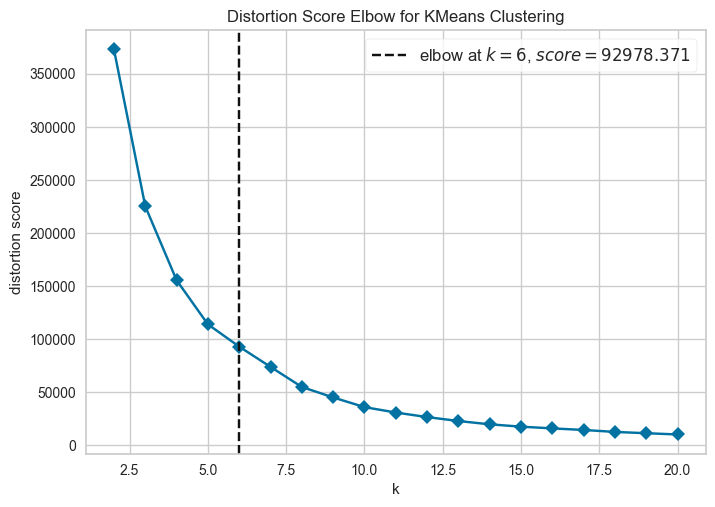

In [47]:
model = KMeans(n_init = 50, random_state = seed)
visualizer = KElbowVisualizer(model, k=n_clusters, timings = False)

visualizer.fit(df7)       
visualizer.show();

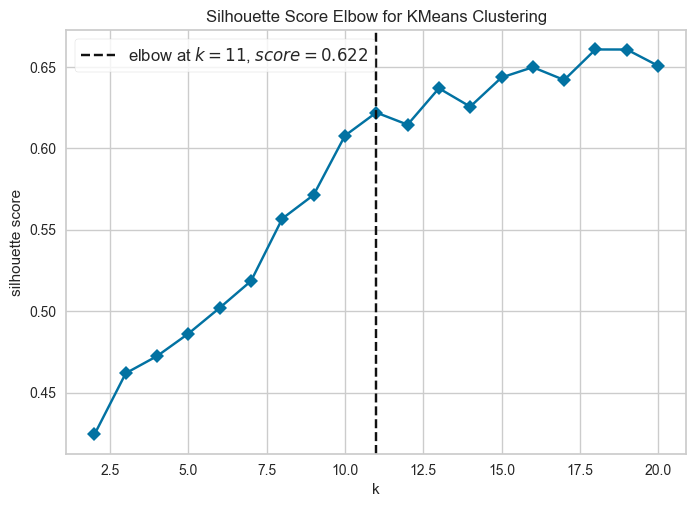

In [48]:
model = KMeans(n_init = 50, random_state = seed)
visualizer = KElbowVisualizer(model, k = n_clusters, timings = False, metric = 'silhouette')

visualizer.fit(df7)       
visualizer.show();

## 7.2. Silhouette Analysis

In [49]:
clusters_list = [9, 11, 13, 16]

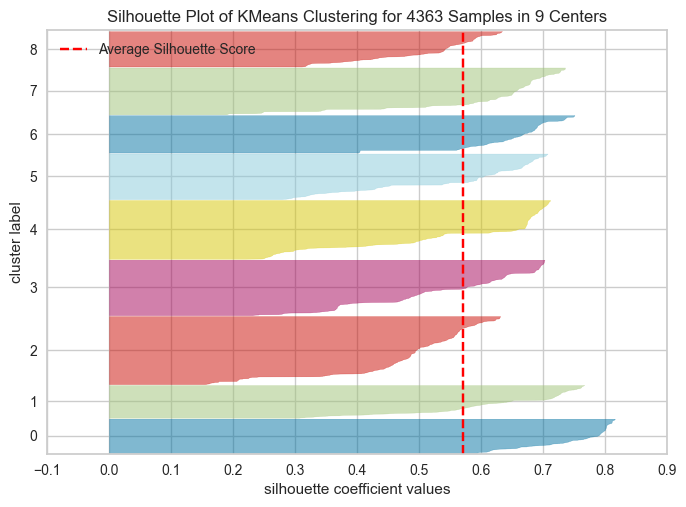

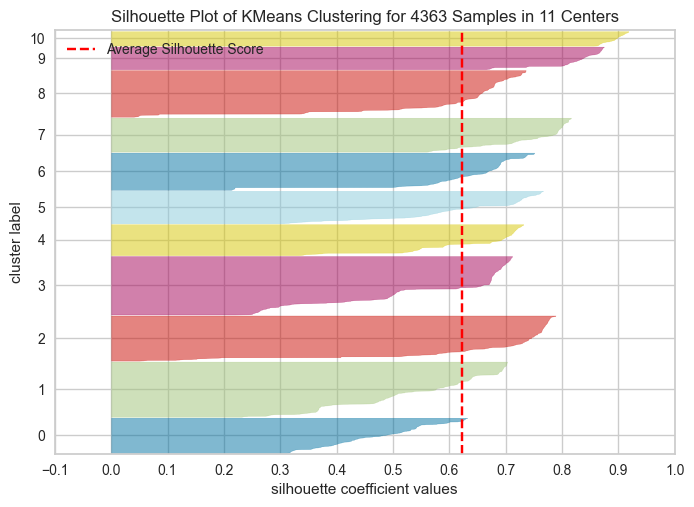

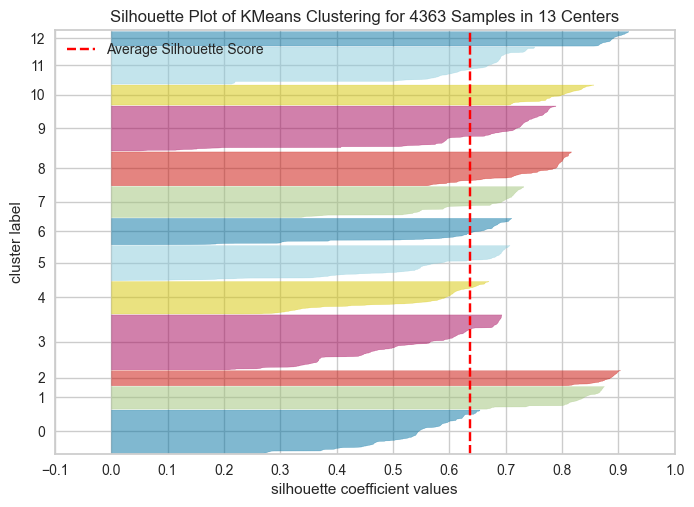

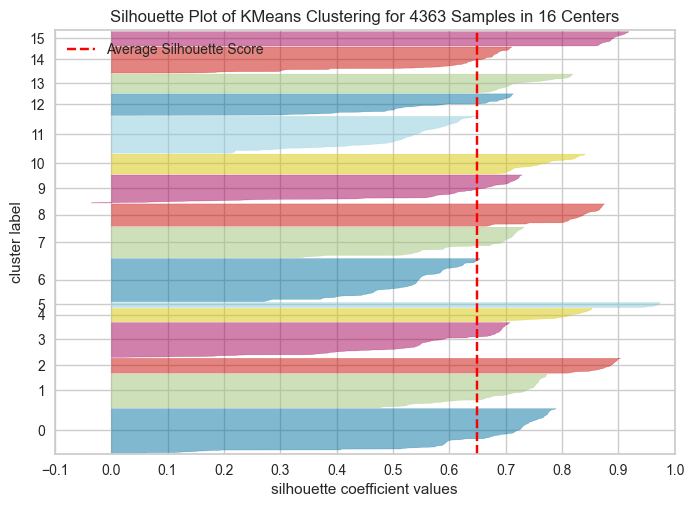

In [50]:
for i in clusters_list:
    model = KMeans(i, n_init = 50, random_state = seed)
    viz = SilhouetteVisualizer(model, colors='yellowbrick')
    viz.fit(df7)       
    viz.show();

## 7.3. K-Means

In [51]:
sil_kmeans = np.array([])
for k in clusters_range:
    model_kmeans = KMeans(n_clusters = k, n_init = 1000, init = 'random', random_state = seed)
    pred_kmeans = model_kmeans.fit_predict(df7)
    
    sil_kmeans = np.append(sil_kmeans, silhouette_score(df7, pred_kmeans))

## 7.4. Hierarchical Clustering

In [52]:
sil_hier = np.array([])
for k in clusters_range:
    model_hier = AgglomerativeClustering(n_clusters = k, affinity='euclidean', linkage='ward')
    pred_hier = model_hier.fit_predict(df7)

    sil_hier = np.append(sil_hier, silhouette_score(df7, pred_hier))

## 7.5. Gaussian Mixture Model

In [53]:
sil_gmm = np.array([])
for k in clusters_range:
    model_gmm = GMM(n_components = k, random_state = seed)
    pred_gmm = model_gmm.fit_predict(df7)
    
    sil_gmm = np.append(sil_gmm, silhouette_score(df7, pred_gmm))

## 7.6. Results

In [54]:
df_result = pd.DataFrame({"K-Means" : sil_kmeans,
                          "Hierarchical" : sil_hier,
                          "GMM": sil_gmm             }).T
df_result.columns = clusters_range
df_result.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
K-Means,0.424336,0.461942,0.472470,0.486249,0.502078,0.518557,0.556893,0.571412,0.607789,0.621966,0.614532,0.636869,0.625594,0.634077,0.649798,0.648207,0.659341,0.629646,0.645406
Hierarchical,0.394832,0.455209,0.470624,0.474875,0.474873,0.507400,0.543935,0.567736,0.605596,0.619861,0.613367,0.635704,0.624362,0.641723,0.650163,0.660556,0.653394,0.653346,0.644023
GMM,0.404916,0.457710,0.435366,0.401943,0.457244,0.493914,0.525897,0.526049,0.548011,0.578742,0.560200,0.584052,0.611393,0.611208,0.623163,0.628972,0.626702,0.639967,0.622702


# 8. MACHINE LEARNING MODELLING

In [55]:
df8 = df7.copy()

## 8.1. Setting Parameters

In [56]:
K = 11

In [57]:
final_model = KMeans(n_clusters = K, n_init = 1000, init = 'random', random_state = seed)
final_pred = final_model.fit_predict(df8)

## 8.2. Cluster Validation

### 8.2.1. Within-Cluster-Sum of Squared Errors 

In [58]:
print("WSS: {:.2f}".format(final_model.inertia_))

WSS: 30920.22


### 8.2.2. Silhouette Score

In [59]:
print("Silhouette Score: {:.4f}".format(silhouette_score(df8, final_pred)))

Silhouette Score: 0.6220


# 9. CLUSTER ANALYSIS

In [60]:
df9 = df5.copy()
final_pred = final_model.fit_predict(df8)
df9['cluster'] = final_pred
df9['CustomerID'] = df4['CustomerID']

df9.head()

,Recency,Frequency,Monetary,AverageTicket,TotalQuantity,AveragePurchaseInterval,cluster,CustomerID
0,325.0,0.000000,0.00,0.000000,74215.0,325.000000,8,12346.0
1,1.0,0.022222,4310.00,615.714286,2458.0,60.333333,3,12347.0
2,74.0,0.011111,1437.24,359.310000,2332.0,94.000000,3,12348.0
3,18.0,0.011111,1457.55,1457.550000,630.0,18.000000,2,12349.0
4,309.0,0.000000,294.40,294.400000,196.0,309.000000,7,12350.0


## 9.1. Silhouette Inspection

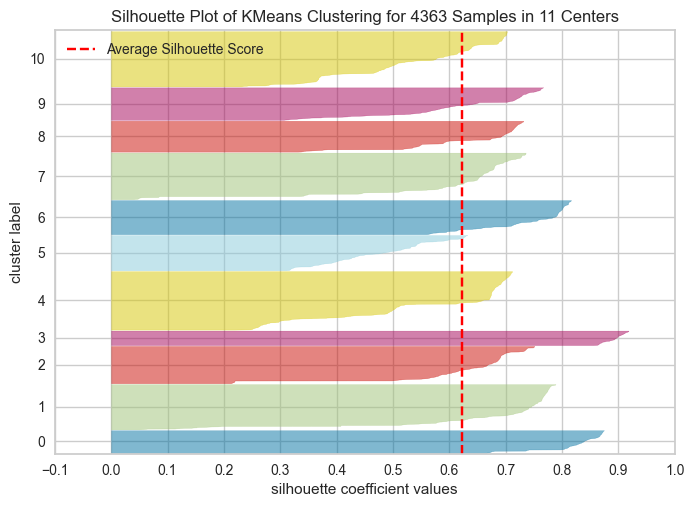

In [61]:
viz = SilhouetteVisualizer(final_model, colors='yellowbrick')
viz.fit(df8)       
viz.show();

## 9.2. 2D Plot

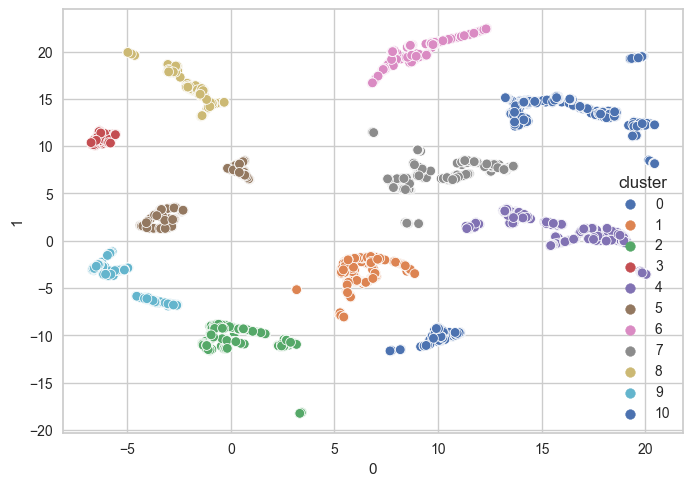

In [62]:
aux = df8.copy()
aux['cluster'] = final_pred

sns.set_palette("bright")
sns.scatterplot(x = 0, y = 1, data = aux, hue = 'cluster', palette = 'deep');

## 9.3. Cluster Profile

In [63]:
count = df9.groupby("cluster").count()[['CustomerID']].rename(columns = {"CustomerID" : "Count"}).reset_index()
count['Percentage'] = count['Count']
customers_num = count['Count'].sum()
count["Percentage"] = count["Percentage"].apply(lambda x: x/customers_num * 100)

In [64]:
df_profile = df9.drop("CustomerID", axis = 1).groupby("cluster").mean().reset_index()
df_profile = count.merge(df_profile, on = 'cluster', how = 'left')

df_profile = df_profile.sort_values("Monetary", ascending = False)
df_profile['Tier'] = ["Premium" , "Sub Premium", 'Gold I', "Gold II", "Silver I", "Silver II", "Bronze I", "Bronze II", "Copper I", "Copper II", "Copper III"]

df_profile

,cluster,Count,Percentage,Recency,Frequency,Monetary,AverageTicket,TotalQuantity,AveragePurchaseInterval,Tier
8,8,327,7.494843,24.269113,0.063880,13472.730489,733.636844,8928.180428,33.672625,Premium
3,3,153,3.506761,29.176471,0.035004,3736.146275,514.935469,2263.405229,49.499706,Sub Premium
5,5,372,8.526243,41.486559,0.024851,2520.349597,414.967185,1585.844086,56.420755,Gold I
9,9,344,7.884483,46.584302,0.021899,1732.334128,389.458844,1057.409884,68.447365,Gold II
2,2,394,9.030484,59.464467,0.017484,1263.378223,360.429564,737.152284,74.981095,Silver I
0,0,239,5.477882,67.305439,0.015156,1161.733808,396.962618,566.384937,85.271738,Silver II
1,1,478,10.955764,87.543933,0.011855,738.806925,308.523514,419.071130,97.747442,Bronze I
4,4,619,14.187486,107.113086,0.008221,483.319111,276.689263,269.961228,115.821808,Bronze II
7,7,493,11.299565,117.286004,0.008542,347.176105,211.900955,177.478702,120.120183,Copper I
10,10,584,13.385285,157.085616,0.005251,248.829966,192.921766,97.731164,155.889139,Copper II


# 10. EXPLORATORY DATA ANALYSIS II

In [65]:
df10 = df9.copy()

**H1. _Premium_ customers bring more than 50% of the total revenue.**

**True:** Premium customers bring 53.16% of the total revenue.

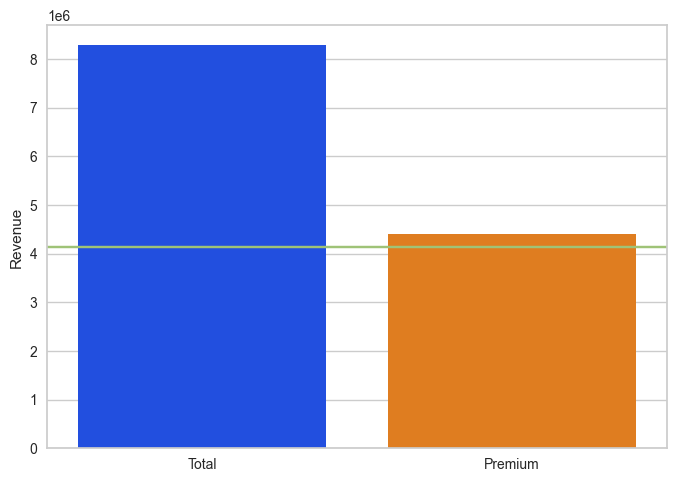

In [66]:
total_income = df10['Monetary'].sum()
premium_income = df10[df10['cluster'] == 8]['Monetary'].sum()

sns.barplot(x = ['Total', "Premium"], y = [total_income, premium_income])
plt.ylabel("Revenue")

plt.axhline(y = total_income/2, color = 'g', linestyle = '-');

In [67]:
print("Premium percentage: {:.2f}%".format(100 * premium_income/total_income))

Premium percentage: 53.16%


**H2. More then 50% of the items sold are bought by _Premium_ customers**

**True:** Around 56.46% of the items sold were bought by _Premium_ customers

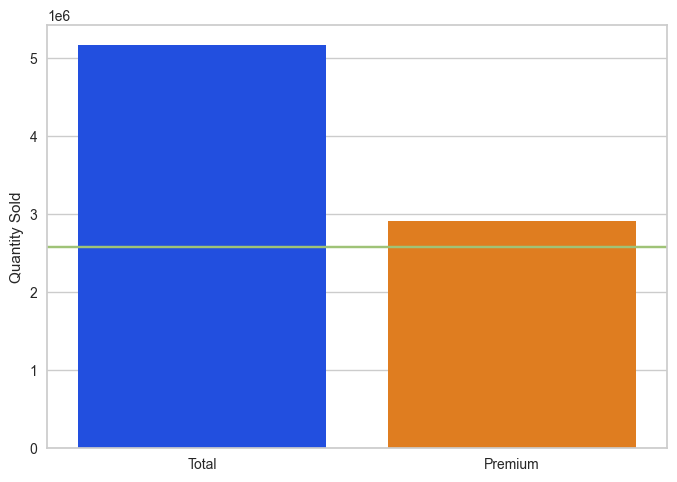

In [68]:
total_items = df10['TotalQuantity'].sum()
premium_items = df10[df10['cluster'] == 8]['TotalQuantity'].sum()

sns.barplot(x = ['Total', "Premium"], y = [total_items, premium_items])
plt.ylabel("Quantity Sold")

plt.axhline(y = total_items/2, color = 'g', linestyle = '-');

In [69]:
print("Premium percentage: {:.2f}%".format(100 * premium_items/total_items))

Premium percentage: 56.46%


**H3. _Copper III_ bring less than 1% of the total revenue.**

**True:** They bring around 0.38% of the total revenue.

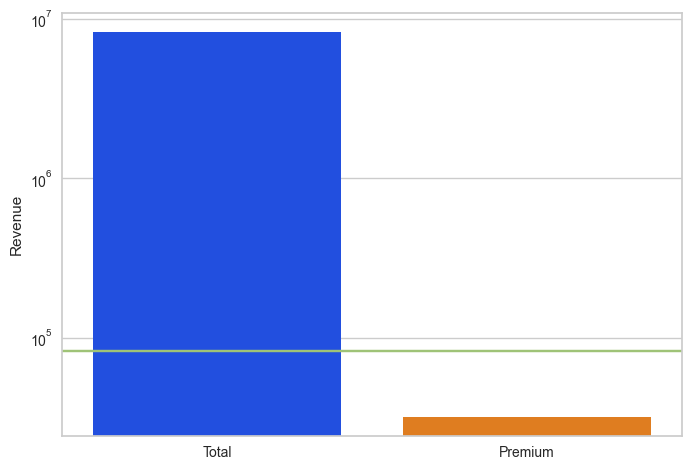

In [70]:
six_income = df10[df10['cluster'] == 6 ]['Monetary'].sum()

sns.barplot(x = ['Total', "Premium"], y = [total_income, six_income])
plt.ylabel("Revenue")

plt.yscale('log')
plt.axhline(y = total_income/100, color = 'g', linestyle = '-');

In [71]:
print("Cluster 6 customer percentage: {:.2f}%".format(100 * six_income/total_income))

Cluster 6 customer percentage: 0.38%


**H4. Cluster _Silver II_ have higher average ticket than the others.** 

**True:** They indeed have it.

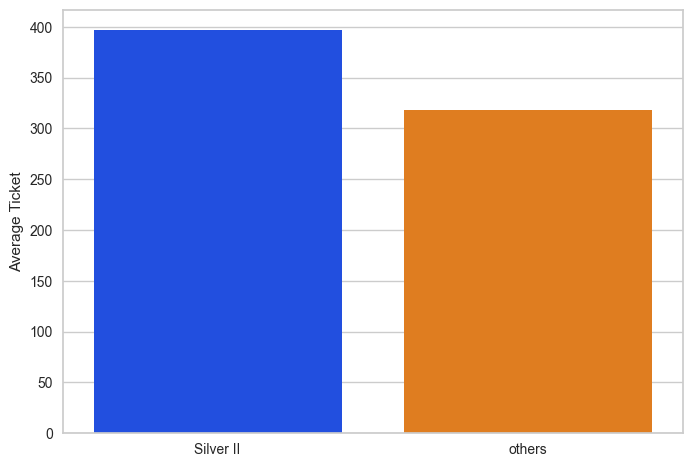

In [72]:
non_zero_AT = df10[df10['cluster'] != 0]['AverageTicket'].mean()
zero_AT = df10[df10['cluster'] == 0]['AverageTicket'].mean()

sns.barplot(x = ["Silver II", 'others'], y = [zero_AT, non_zero_AT])
plt.ylabel("Average Ticket");

**H5. Clusters _Copper_ added up bring less than 10% of the total revenue.**

**True:** They added up bring around 4.20% of the total revenue.

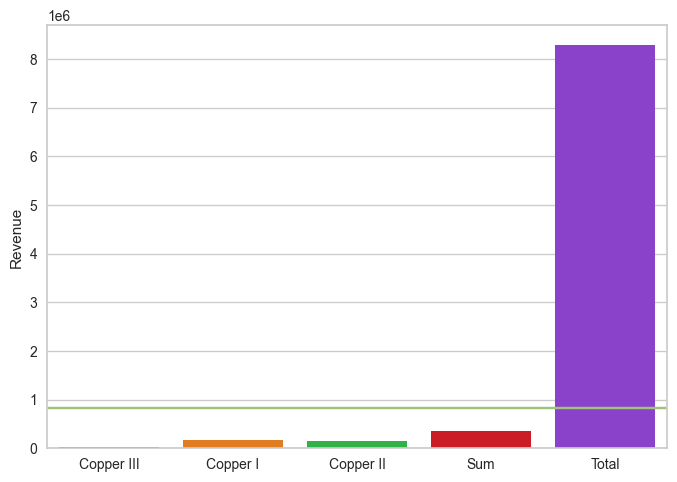

In [73]:
seven_income = df10[df10['cluster'].isin([7])]['Monetary'].sum()
ten_income = df10[df10['cluster'].isin([10])]['Monetary'].sum()
sum_income = df10[df10['cluster'].isin([6, 7, 10])]['Monetary'].sum()

sns.barplot(x = ["Copper III", "Copper I", "Copper II", "Sum", "Total"], y = [six_income, seven_income, ten_income, sum_income, total_income])
plt.ylabel("Revenue")

plt.axhline(total_income/10, color = 'g', linestyle = '-');

In [74]:
print("Sum percentage: {:.2f}%".format(100 * sum_income/total_income))

Sum percentage: 4.20%


**H6. Cluster _Gold I_, _Sub Premium_, and _Premium_ customers added up bring more than 80% of the revenue.**

**False:** They bring around 71.38%.

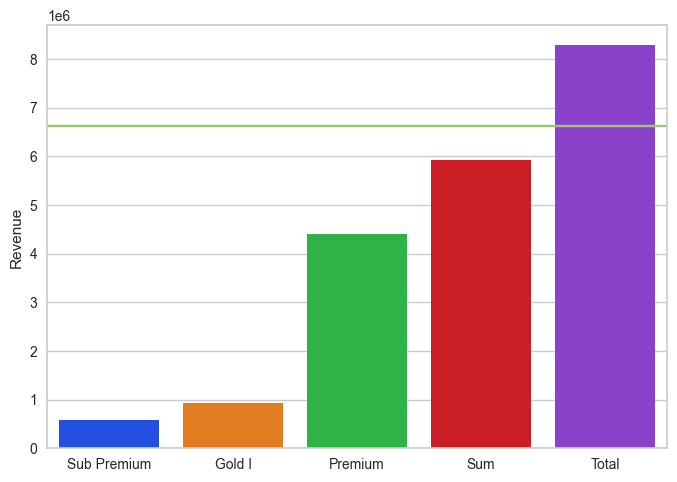

In [75]:
three_income = df10[df10['cluster'] == 3]['Monetary'].sum()
five_income = df10[df10['cluster'] == 5]['Monetary'].sum()
eight_income = df10[df10['cluster'] == 8]['Monetary'].sum()
sum_income = three_income + five_income + eight_income

sns.barplot(x = ["Sub Premium", "Gold I", "Premium", "Sum", "Total"], y = [three_income, five_income, eight_income, sum_income, total_income])
plt.ylabel("Revenue")

plt.axhline(8*total_income/10, color = 'g', linestyle = '-');

In [76]:
print("Sum percentage: {:.2f}%".format(100 * sum_income/total_income))

Sum percentage: 71.38%
